In [7]:
## import packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow import keras

In [5]:
## set up to split images into training and test set
from sklearn.model_selection import train_test_split


def split_images(csv_path, test_size=0.2, random_state=42):
    # Load the CSV file
    data = pd.read_csv(csv_path)

    # Assume the CSV has at least two columns: 'filename' and 'label'
    # If the CSV structure is different, modify accordingly
    filenames = data["image"]
    labels = data["labels"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        filenames,
        labels,
        test_size=test_size,
        random_state=random_state,
        stratify=labels,
    )

    # Create DataFrames for training and testing sets
    train_df = pd.DataFrame({"image": X_train, "labels": y_train})
    test_df = pd.DataFrame({"image": X_test, "labels": y_test})

    return train_df, test_df


## run

csv_path = "datasets/catdog/cat_dog.csv"
gloss_catdog = pd.read_csv(csv_path)
print(gloss_catdog.head())


train_df, test_df = split_images(csv_path)

# Optionally, save the DataFrames to CSV files
train_df.to_csv("datasets/catdog/train_images.csv", index=False)
test_df.to_csv("datasets/catdog/test_images.csv", index=False)

# Display the first few rows of the DataFrames
print(train_df.head())
print(test_df.head())

           image  labels
0  dog.11289.jpg       1
1  cat.10836.jpg       0
2   cat.7970.jpg       0
3   cat.2212.jpg       0
4   dog.2653.jpg       1
               image  labels
14949  dog.10901.jpg       1
10006   cat.1420.jpg       0
24551   dog.7506.jpg       1
2625    dog.7122.jpg       1
15921   dog.1586.jpg       1
               image  labels
6237   dog.10138.jpg       1
12482   dog.6839.jpg       1
17892   cat.8509.jpg       0
8016    cat.3989.jpg       0
5530    dog.2713.jpg       1


In [3]:
## setup for is.dog 2.0 -> classification of images into dog vs cat
## set up data -> set up dataloaders


# Function to load images and labels from a DataFrame
def load_images_from_dataframe(
    dataframe,
    img_height,
    img_width,
    batch_size,
    data_augmentation=False,
    base_dir="datasets/catdog/cat_dog",
):
    dataframe["image"] = base_dir + "/" + dataframe["image"]
    dataframe["labels"] = dataframe["labels"].astype(str)  # Convert labels to string

    print("First few rows of the dataframe with updated paths:")
    print(dataframe.head())

    if data_augmentation:
        datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest",
        )
    else:
        datagen = ImageDataGenerator(rescale=1.0 / 255)

    generator = datagen.flow_from_dataframe(
        dataframe,
        x_col="image",
        y_col="labels",
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
    )

    return generator


# Load the CSV data
train_df = pd.read_csv("datasets/catdog/train_images.csv")
test_df = pd.read_csv("datasets/catdog/test_images.csv")

# Display the first few rows of the DataFrames
# print(train_df.head())
# print(test_df.head())

# Image dimensions and parameters
img_height, img_width = 150, 150
batch_size = 32
num_classes = len(train_df["labels"].unique())

print(num_classes)

# Create data generators
train_generator = load_images_from_dataframe(
    train_df, img_height, img_width, batch_size, data_augmentation=True
)
test_generator = load_images_from_dataframe(
    test_df, img_height, img_width, batch_size, data_augmentation=False
)

2
First few rows of the dataframe with updated paths:
                                   image labels
0  datasets/catdog/cat_dog/dog.10901.jpg      1
1   datasets/catdog/cat_dog/cat.1420.jpg      0
2   datasets/catdog/cat_dog/dog.7506.jpg      1
3   datasets/catdog/cat_dog/dog.7122.jpg      1
4   datasets/catdog/cat_dog/dog.1586.jpg      1
Found 20000 validated image filenames belonging to 2 classes.
First few rows of the dataframe with updated paths:
                                   image labels
0  datasets/catdog/cat_dog/dog.10138.jpg      1
1   datasets/catdog/cat_dog/dog.6839.jpg      1
2   datasets/catdog/cat_dog/cat.8509.jpg      0
3   datasets/catdog/cat_dog/cat.3989.jpg      0
4   datasets/catdog/cat_dog/dog.2713.jpg      1
Found 5000 validated image filenames belonging to 2 classes.


In [21]:
## test the generators!!
import matplotlib.pyplot as plt
import PIL.Image


# Function to test the data generators
def test_gen(generator, num_batches=1):
    """
    Test the generator by printing the shapes of the images and labels in a few batches
    and displaying some sample images.
    """
    # Get a batch of images and labels
    images, labels = next(generator)

    # Print the shapes of the images and labels
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

    # Display some sample images and their labels
    for i in range(min(num_batches * generator.batch_size, len(images))):
        plt.figure(figsize=(2, 2))
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].argmax()}")
        plt.axis("off")
        plt.show()

    return images, labels


# Test the train_generator
print("Testing train_generator:")
# train_images, train_labels = test_gen(train_generator)

# Test the test_generator
print("Testing test_generator:")
# test_images, test_labels = test_gen(test_generator)

Testing train_generator:
Testing test_generator:


In [22]:
# Building the CNN model
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# Image dimensions and parameters
img_height, img_width = 150, 150
batch_size = 32
num_classes = len(train_df["labels"].unique())
num_epochs = 50


# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size // 10,
    epochs=num_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size // 10,
)

# Evaluating the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the model
model.save("isdog2_models/isdogv2_0_20epochs.h5")

c:\Users\dvait\Desktop\GitRepos\CWLWDL\CWL_WDL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.5131 - loss: 0.7271

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


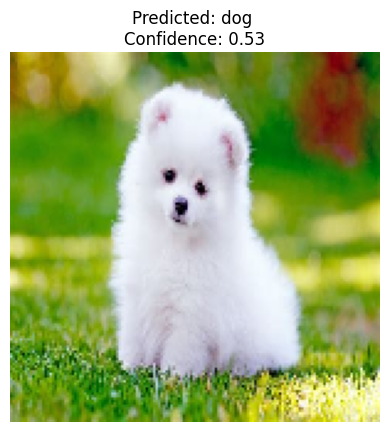

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model("isdog2_models/isdogv2_0_20epochs.h5")


# Function to preprocess the image
def preprocess_image(img_path, img_height=150, img_width=150):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale to [0, 1]
    return img_array


# Function to classify an image
def classify_image(model, img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]

    return predicted_class, predictions


# Function to display an image with its predicted class
def display_image_with_prediction(model, img_path, class_names):
    # Preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0  # Rescale to [0, 1]

    # Get the predicted class
    predicted_class, predictions = classify_image(model, img_path)

    # Display the image
    plt.imshow(img_array)
    plt.title(
        f"Predicted: {class_names[predicted_class]} \nConfidence: {predictions[0][predicted_class]:.2f}"
    )
    plt.axis("off")
    plt.show()


# Example of preprocessing an image
img_path = (
    "datasets/catdog/test_images/003.jpg"  # Replace with the path to your new image
)

class_names = ["cat", "dog"]  # Replace with your actual class names

display_image_with_prediction(model, img_path, class_names)

display_image_with_prediction(model, "datasets/catdog/test_images/002.jpg", class_names)